In [38]:
import pandas as pd
import numpy as  np
from scipy.optimize import minimize
import random
from sklearn.metrics import mean_squared_error as mse
import time

In [2]:
ratings_small = np.genfromtxt('ratings.csv',delimiter=',',skip_header =1)[:,0:3]

In [3]:
def get_rhat(u,v):
    return np.matmul(u,np.transpose(v))

In [4]:
def cal_error(r,rhat):
    return 0.5 * np.sum(np.square(r - rhat))

![Matrix Factorization](img/algo.png)

In [11]:
def matrix_factorization(ratings,alpha,steps,k=3):
    r=ratings
    row = (r.shape[0])
    col = (r.shape[1])
    
    np.random.seed(1234)
    u = np.random.rand(row,k)
    v = np.random.rand(col,k)
    
    e = r - get_rhat(u,v)
    e = np.array(pd.DataFrame(e).fillna(0))

    for s in range(steps):
        u_c = u + alpha * np.matmul(e,v)
        v_c = v + alpha * np.matmul(np.transpose(e),u)
       
        u = np.copy(u_c)
        v = np.copy(v_c)
        e = r - get_rhat(u,v)
        e = np.array(pd.DataFrame(e).fillna(0))
    return get_rhat(u,v)

## Implementing on a Sample Case

In [17]:
R = [[5,3,np.nan,1],[4,np.nan,np.nan,1],[1,1,np.nan,5],[1,np.nan,np.nan,4],[np.nan,1,5,4]]
R = np.array(R)
R

array([[ 5.,  3., nan,  1.],
       [ 4., nan, nan,  1.],
       [ 1.,  1., nan,  5.],
       [ 1., nan, nan,  4.],
       [nan,  1.,  5.,  4.]])

In [18]:
predicted_R = matrix_factorization(R,0.002,1000,k=3)
predicted_R

array([[5.00479217, 2.98757696, 3.29128869, 0.99876123],
       [3.99561129, 2.12559217, 3.00200174, 0.99823669],
       [1.01425366, 0.96503099, 4.64540656, 4.997607  ],
       [0.99271356, 0.4237421 , 4.14724211, 3.99633337],
       [2.37957614, 1.04454135, 4.98434807, 4.01184795]])

In [19]:
true = [[0,0],[0,1],[0,3],[1,0],[1,3],[2,0],[2,1],[2,3],[3,0],[3,3],[4,1],[4,2],[4,3]]

In [20]:
def fetch_ratings(ratings, predicted, coords):
    y_true = list()
    y_pred = list()
    for i in coords:
        y_true.append(ratings[i[0]][i[1]])
        y_pred.append(predicted[i[0]][i[1]])
    return(y_true,y_pred)

In [21]:
y_true, y_pred = fetch_ratings(R, predicted_R, true)

In [23]:
print('RMSE:', np.sqrt(mse(y_true, y_pred)))

RMSE: 0.017691266300768293


## Experiment 1: Small Dataset [ 640 Users x 100 Movies]

In [27]:
ratings = pd.read_csv('ratings.csv')

In [39]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [47]:
print(' Number of Users:', len(ratings.userId.unique()),'\n','Number of Movies:', len(ratings.movieId.unique()))

 Number of Users: 610 
 Number of Movies: 9724


In [133]:
# Selecting Top 100 Movies
data = ratings

common_movies = data.groupby('movieId').size().reset_index(name='counts')
common_movies = common_movies.sort_values(ascending=False, by=['counts']);
movies = list(common_movies.head(100)['movieId']);
#movies

In [56]:
r2 = ratings.pivot(index='userId', columns='movieId', values='rating');
r2_ = r2.filter(items = movies)
r3 = np.asarray(r2_)

In [53]:
r2_.shape

(610, 100)

In [57]:
def get_indices(data):
    indice = list()
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if np.isnan(data[i][j]) == False:
                indice.append([i,j])
            else:
                pass
    return(indice)

In [58]:
indice = get_indices(r3)
print('Number of Available Data Points:', len(indice))

Number of Available Data Points: 16185


In [59]:
print('Total number of possible entries in Data Matrix:', r3.shape[0]*r3.shape[1])

Total number of possible entries in Data Matrix: 61000


In [61]:
print('Sparsity of Given Data Matrix: {} %'.format( (1 - (16185)/61000.0)*100 )) 

Sparsity of Given Data Matrix: 73.4672131147541 %


In [62]:
ratio = 0.1

In [63]:
import time

start = time.time()
matrix_factorization(r3,0.0002,1000)
end = time.time()

print('Time Taken:', end-start)

Time Taken: 1.517120122909546


In [64]:
def select_test(indice, ratio):
    random.seed(2018)
    test = random.sample(indice, int(ratio*len(indice)))
    return(test)

In [65]:
test = select_test(indice, 0.1)

In [66]:
def mutate_ratings(ratings,test):
    rt = ratings.copy()
    for i in test:
        rt[i[0]][i[1]] = np.nan
    return (rt)

In [67]:
# Masking known entries kept in Test Set to predict during Matrix Factorization
new_r3 = mutate_ratings(r3, test)

In [68]:
start = time.time()
pred_new_r3_1 = matrix_factorization(new_r3, alpha = 0.0002, steps = 1000, k = 1)
end1 = time.time()
print(end1-start)

pred_new_r3_2 = matrix_factorization(new_r3, alpha = 0.0002, steps = 1000, k = 2)
end2 = time.time()
print(end2-start)

pred_new_r3_3 = matrix_factorization(new_r3, alpha = 0.0002, steps = 1000, k = 3)
end3 = time.time()
print(end3-start)

pred_new_r3_4 = matrix_factorization(new_r3, alpha = 0.0002, steps = 1000, k = 4)
end4 = time.time()
print(end4-start)

pred_new_r3_5 = matrix_factorization(new_r3, alpha = 0.0002, steps = 1000, k = 5)
end5 = time.time()
print(end5-start)

1.305593729019165
2.807147741317749
4.380727767944336
5.8179309368133545
7.307520627975464


In [69]:
from tqdm import tqdm

In [106]:
def rmse_k(data, k):
    indice = get_indices(data)
    ratios = [0.1, 0.3, 0.5, 0.7, 0.9]
    
    scores = dict()
    
    for ratio in tqdm(ratios):
        test = select_test(indice, ratio)
        new_data = mutate_ratings(data, test)
        pred = matrix_factorization(new_data,0.0002,1000, k = k)
        y_true, y_pred = fetch_ratings(data, pred, test)
        score = np.sqrt(mse(y_true, y_pred))
        scores[str(ratio)] = score
        
    return(scores)

In [107]:
def fetch_ratings(ratings, predicted, coords):
    y_true = list()
    y_pred = list()
    for i in coords:
        y_true.append(ratings[i[0]][i[1]])
        y_pred.append(predicted[i[0]][i[1]])
    return(y_true,y_pred)

In [108]:
val_1 = rmse_k(r3, k= 1)

100%|██████████| 5/5 [00:06<00:00,  1.26s/it]


In [109]:
val_2 = rmse_k(r3, k= 2)

100%|██████████| 5/5 [00:06<00:00,  1.30s/it]


In [110]:
val_3 = rmse_k(r3, k= 3)

100%|██████████| 5/5 [00:06<00:00,  1.34s/it]


In [111]:
val_4 = rmse_k(r3, k= 4)

100%|██████████| 5/5 [00:06<00:00,  1.35s/it]


In [112]:
val_5 = rmse_k(r3, k= 5)

100%|██████████| 5/5 [00:06<00:00,  1.37s/it]


In [113]:
val_6 = rmse_k(r3, k= 6)

100%|██████████| 5/5 [00:06<00:00,  1.40s/it]


In [114]:
np.save('val_1.npy', val_1) 
np.save('val_2.npy', val_2) 
np.save('val_3.npy', val_3)
np.save('val_4.npy', val_4)
np.save('val_5.npy', val_5)
np.save('val_6.npy', val_6)

In [115]:
val_1 = np.load('val_1.npy').item()
val_2 = np.load('val_2.npy').item()
val_3 = np.load('val_3.npy').item()
val_4 = np.load('val_4.npy').item()
val_5 = np.load('val_5.npy').item()
val_6 = np.load('val_6.npy').item()

In [116]:
ratios = [0.1, 0.3, 0.5, 0.7, 0.9]

In [117]:
v1 = [val_1[str(key)] for key in ratios ]
v2 = [val_2[str(key)] for key in ratios ]
v3 = [val_3[str(key)] for key in ratios ]
v4 = [val_4[str(key)] for key in ratios ]
v5 = [val_5[str(key)] for key in ratios ]
v6 = [val_6[str(key)] for key in ratios ]

In [134]:
# Sample of RMSE values stored for k= 2 for varying Train-Test split sizes
v2

[0.8290467959649,
 0.8385967568916038,
 0.8735805945898467,
 0.910607326797644,
 1.1060615282910478]

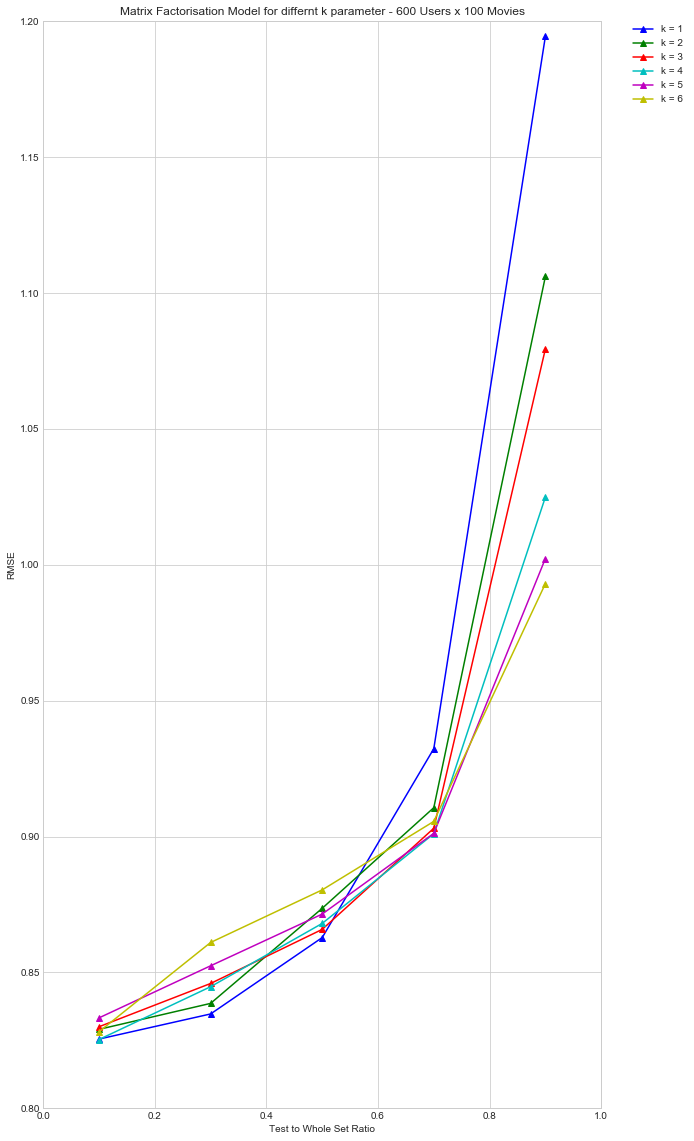

In [135]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,20))
plt.style.use('seaborn-whitegrid')

ratios = [0.1, 0.3, 0.5, 0.7, 0.9]

plt.plot(ratios, v1,'b^-', label='k = 1')
plt.plot(ratios, v2,'g^-', label='k = 2')
plt.plot(ratios, v3,'r^-', label='k = 3')
plt.plot(ratios, v4,'c^-', label='k = 4')
plt.plot(ratios, v5,'m^-', label='k = 5')
plt.plot(ratios, v6,'y^-', label='k = 6')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Matrix Factorisation Model for differnt k parameter - 600 Users x 100 Movies')
plt.xlabel('Test to Whole Set Ratio')
plt.ylabel('RMSE')
plt.xlim(0, 1.0)
plt.ylim(0.8, 1.2)
plt.savefig('img/MF-small.png')
plt.show()

## Experiment 2- Large Dataset [ 10,000 Users x 100 Movies]